# Fig. 3: Two impurities

In [17]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from amsc import (
    impurity_system,
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
)
from plot_tools import add_tl_label, complex_plot, multiplot
from scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import thermal_broadening, sparse_diag, sort_eigensystem

In [18]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [19]:
plt.style.use("../plot_style.mplstyle")

In [20]:
periodic_bc = True

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [21]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [22]:
# Impurituy positions
impurity_positions = [(0, 0), (0, 0)]  # , (-10, 0)]
impurity_sizes = [2.2, 2.2]  # Sizes
impurity_eccentricities = [0.0, 0.0]  # Eccentricity
impurity_orientation = [0.0, 0.0]  # Orientation


V_imp = [-19, -19]  # Impurity potential (negative = attractive)
hx_imp = [0.0, 0.0]  # Impurity field
hy_imp = [0.0, 0.0]  # Impurity field
hz_imp = [0.0, 0.0]  # Impurity field

## Distance

In [23]:
N = 100

In [24]:
ds = np.arange(26, 1, -1)
P = len(ds)

wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, d in tqdm(enumerate(ds), total=len(ds)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions=[(0.0, 0.0), (0.0, +d)],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/25 [00:00<?, ?it/s]

In [25]:
wss, vss = sort_eigensystem(wss, vss)

In [26]:
idxs = (-1 / (wss[0])).argsort()

In [27]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [28]:
szs = np.zeros((P, 4))

for n in range(4):
    for p in range(P):
        szs[p, n] = t0sz_op(vss[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(P):
    for n in range(4):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)

markers = np.zeros((P, N), dtype=str)
markers[:] = "."

# for p in range(P):
#     for n in range(4):
#         markers[p, idxs[n]] = '^' if n%2==0 else 's'

linestyles = np.zeros(N, dtype="<U2")
linestyles[:] = "--"

for n in range(4):
    linestyles[idxs[n]] = "-" if n % 2 == 0 else "--"

In [29]:
idxp = np.argwhere(ds == 11)[0][0]

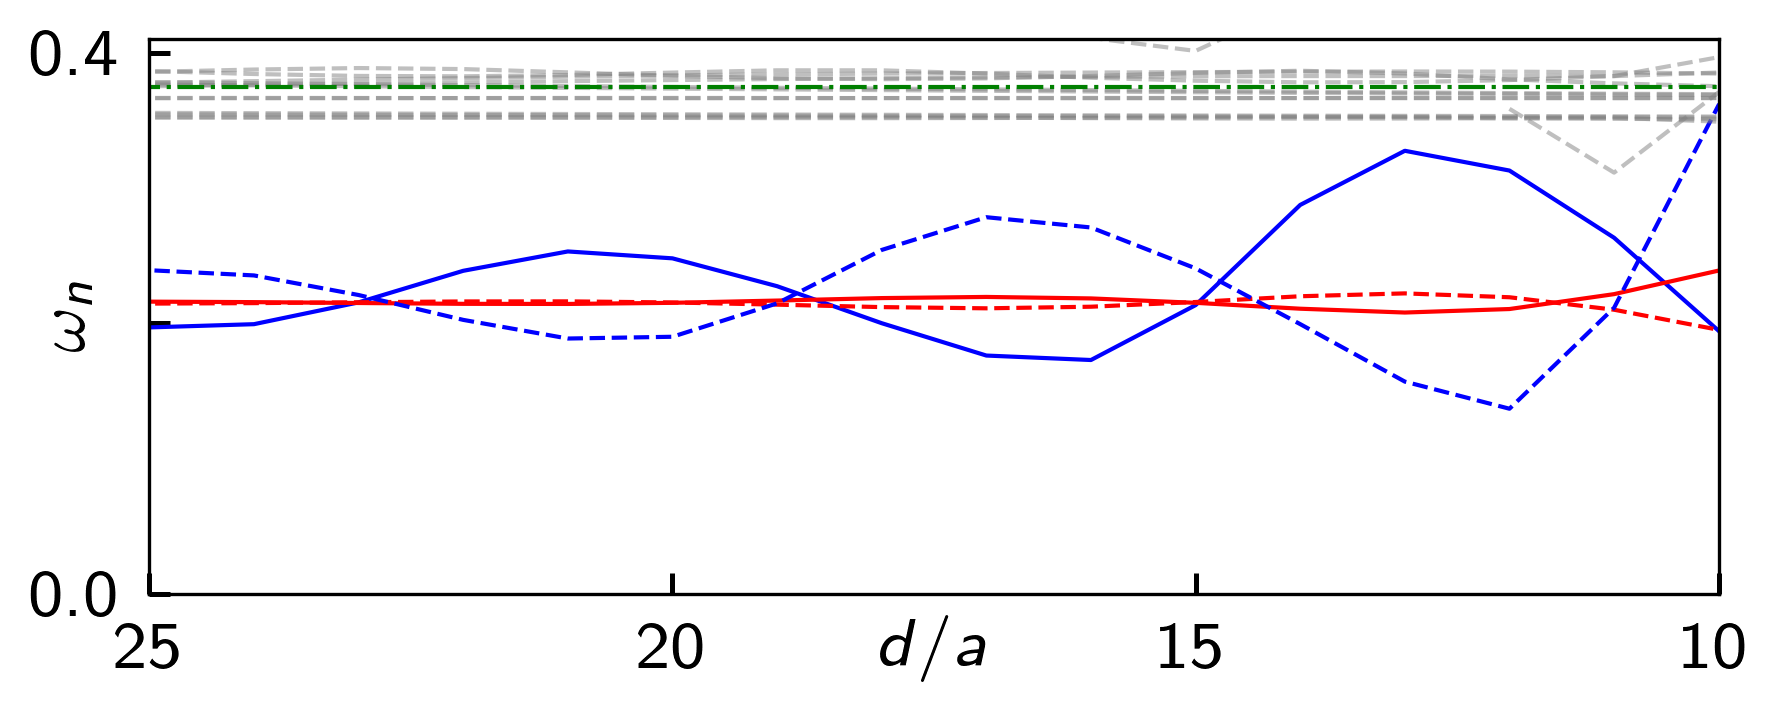

In [30]:
fig, ax = plt.subplots(figsize=(3.375, 1.2))

for i in range(N):
    ax.plot(ds[:], wss[:, i], linestyle=linestyles[i], marker="", color=colors[0, i])


ax.plot(ds, Delta_init - mu * t_am / t + 0 * ds, "-.", color="green")
ax.plot(ds, -Delta_init + mu * t_am / t + 0 * ds, "-.", color="green")

# ax.vlines(ds[idxp], -0.43, 0.43, colors="k", linestyles="--")

ax.set_xticks([25, 20, 15, 10])
ax.set_yticks([0.0, 0.2, 0.4], labels=["0.0", "", "0.4"])

ax.set_xlabel(r"$d/a$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.41)
ax.set_xlim(25, 10)

fig.savefig("./imgs/Fig3_plot_v19w22.svg", dpi=1200)

/tmp/ipykernel_116253/2021672607.py:38: RuntimeWarning: plotly is not available, if other engines are unavailable, only iterator-providing functions will work
  im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)


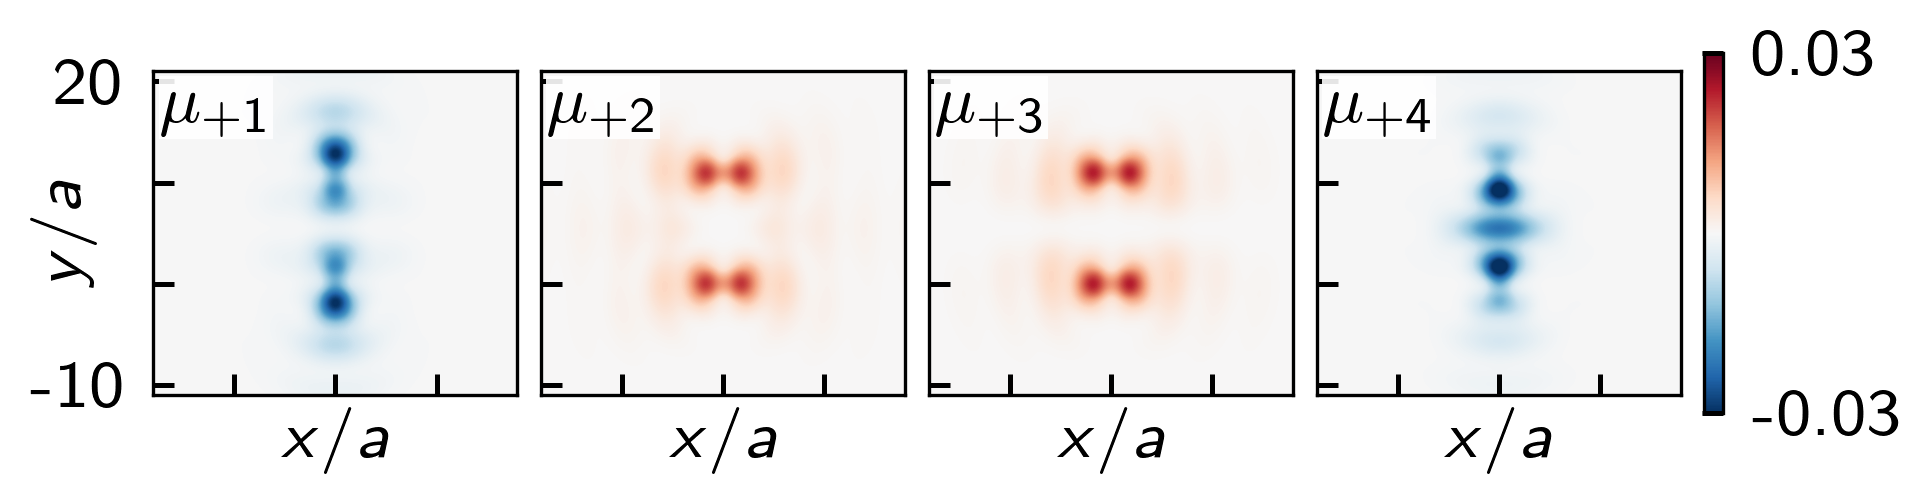

In [31]:
d_1 = t0s0_op(vss[idxp, :, idxs[0]])
d_2 = t0s0_op(vss[idxp, :, idxs[1]])
d_3 = t0s0_op(vss[idxp, :, idxs[2]])
d_4 = t0s0_op(vss[idxp, :, idxs[3]])

m_1 = t0sz_op(vss[idxp, :, idxs[0]])
m_2 = t0sz_op(vss[idxp, :, idxs[1]])
m_3 = t0sz_op(vss[idxp, :, idxs[2]])
m_4 = t0sz_op(vss[idxp, :, idxs[3]])


# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.78))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

# # Determine color limits
# vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
# vmin = 0

# im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap="Grays", vmin=vmin, vmax=vmax)
# im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap="Grays", vmin=vmin, vmax=vmax)
# im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap="Grays", vmin=vmin, vmax=vmax)
# im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap="Grays", vmin=vmin, vmax=vmax)

# Determine color limits
vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))
vmin = -vmax

# Plot densities with kwant.plotter.density
im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=["-10", "", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{+2}$")
add_tl_label(ax3, r"$\mu_{+3}$")
add_tl_label(ax4, r"$\mu_{+4}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content
plt.savefig("./imgs/Fig3_spins_v19w22.svg", dpi=1200)

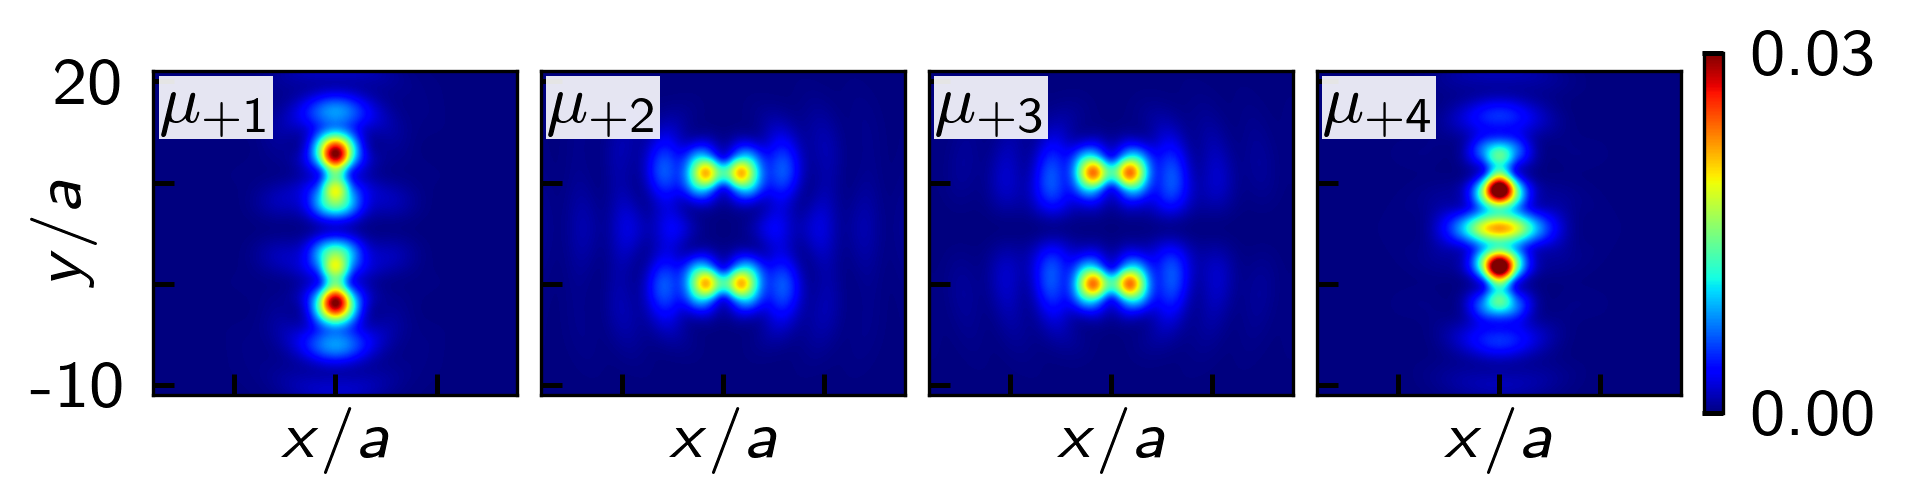

In [32]:
d_1 = t0s0_op(vss[idxp, :, idxs[0]])
d_2 = t0s0_op(vss[idxp, :, idxs[1]])
d_3 = t0s0_op(vss[idxp, :, idxs[2]])
d_4 = t0s0_op(vss[idxp, :, idxs[3]])

m_1 = t0sz_op(vss[idxp, :, idxs[0]])
m_2 = t0sz_op(vss[idxp, :, idxs[1]])
m_3 = t0sz_op(vss[idxp, :, idxs[2]])
m_4 = t0sz_op(vss[idxp, :, idxs[3]])


# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.78))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = 0

cmap = "jet"
im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax)
im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax)
im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax)
im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax)

# # Determine color limits
# vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))
# vmin = -vmax

# # Plot densities with kwant.plotter.density
# im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=["-10", "", "", "20"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{+2}$")
add_tl_label(ax3, r"$\mu_{+3}$")
add_tl_label(ax4, r"$\mu_{+4}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap=cmap)
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])
plt.savefig("imgs/Fig3_ldos_v19w22.svg", dpi=1200)

## Angle

In [33]:
d = 16

In [34]:
phis = np.linspace(0, np.pi, 33)

In [35]:
# np.around(d * np.array([np.sin(phis), np.cos(phis)])).T

In [36]:
N = 60

In [37]:
P = len(phis)

wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, phi in tqdm(enumerate(phis), total=len(phis)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=impurity_sizes,
        impurity_positions=[
            (0, 0),
            (np.around(d * np.sin(phi)), np.around(d * np.cos(phi))),
        ],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/33 [00:00<?, ?it/s]

In [38]:
wss, vss = sort_eigensystem(wss, vss)

In [39]:
idxs = (-1 / (wss[0])).argsort()

In [40]:
szs = np.zeros((P, 4))

for n in range(4):
    for p in range(P):
        szs[p, n] = t0sz_op(vss[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 1)

for p in range(P):
    for n in range(4):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)


markers = np.zeros((P, N), dtype=str)
markers[:] = "."

for p in range(P):
    for n in range(4):
        markers[p, idxs[n]] = "x" if n % 2 == 0 else "+"

linestyles = np.zeros(N, dtype="<U2")
linestyles[:] = "--"

for n in range(4):
    linestyles[idxs[n]] = "-" if n % 2 == 0 else "--"

In [41]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

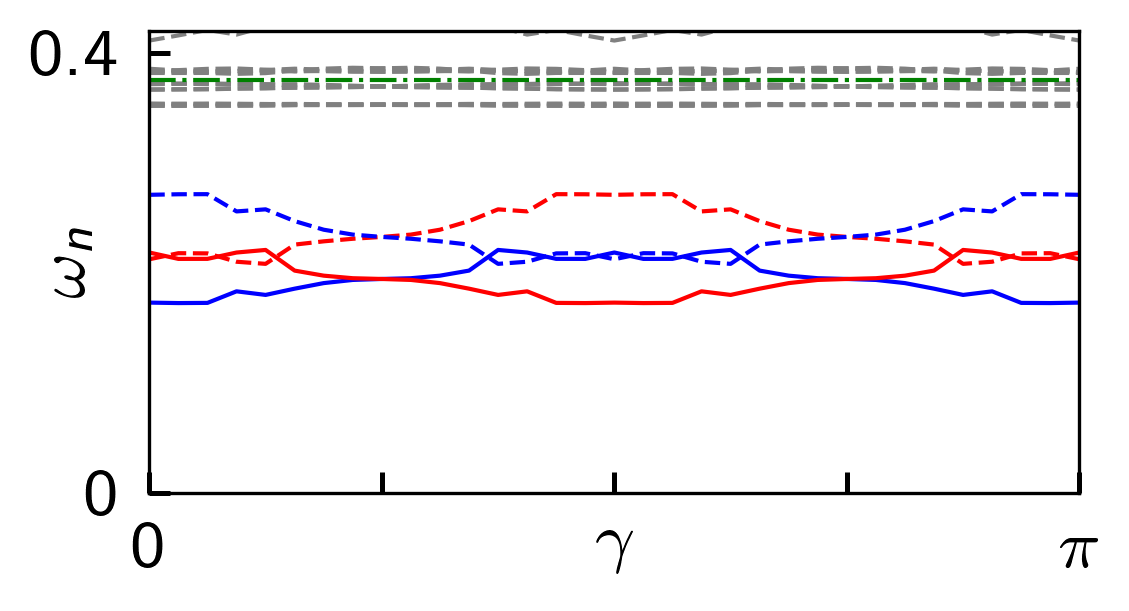

In [42]:
fig, ax = plt.subplots(figsize=(2, 1.0))

for i in range(N):
    ax.plot(
        phis[:] / np.pi,
        wss[:, i],
        linestyle=linestyles[i],
        marker="",
        markersize=0.2,
        color=colors[0, i],
    )

ax.plot(
    phis / np.pi, Delta_init - mu * t_am / t + 0 * phis / np.pi, "-.", color="green"
)
ax.plot(
    phis / np.pi, -Delta_init + mu * t_am / t + 0 * phis / np.pi, "-.", color="green"
)


ax.set_xticks([0, 0.25, 0.5, 0.75, 1], labels=["0", "", "", "", r"$\pi$"])
ax.set_yticks([0, 0.4], labels=["0", "0.4"])

ax.set_xlabel(r"$\gamma$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.42)
ax.set_xlim(0, 1)

fig.savefig("./imgs/Fig3_angle_v19w22.svg", dpi=1200)

# Fig 4: Two impurities in magnetic field

In [43]:
N = 160
d = 12

In [44]:
bs = np.linspace(-0.2, 0.2, 21)
P = len(bs)

In [45]:
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, bz in tqdm(enumerate(bs), total=len(bs)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=bz,
        impurity_sizes=impurity_sizes,
        impurity_positions=[(0.0, 0.0), (0.0, d)],
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=V_imp,
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

  0%|          | 0/21 [00:00<?, ?it/s]

In [46]:
wss, vss = sort_eigensystem(wss, vss)

In [47]:
idxs = (abs(wss[P // 2])).argsort()

In [48]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

In [49]:
szs = np.zeros((P, 8))

for n in range(8):
    for p in range(P):
        szs[p, n] = t0sz_op(vss[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(P):
    for n in range(8):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)


linestyles = np.zeros(N, dtype="<U2")
linestyles[:] = "--"

for n in range(4):
    linestyles[idxs[n]] = "-" if n % 2 == 0 else "--"

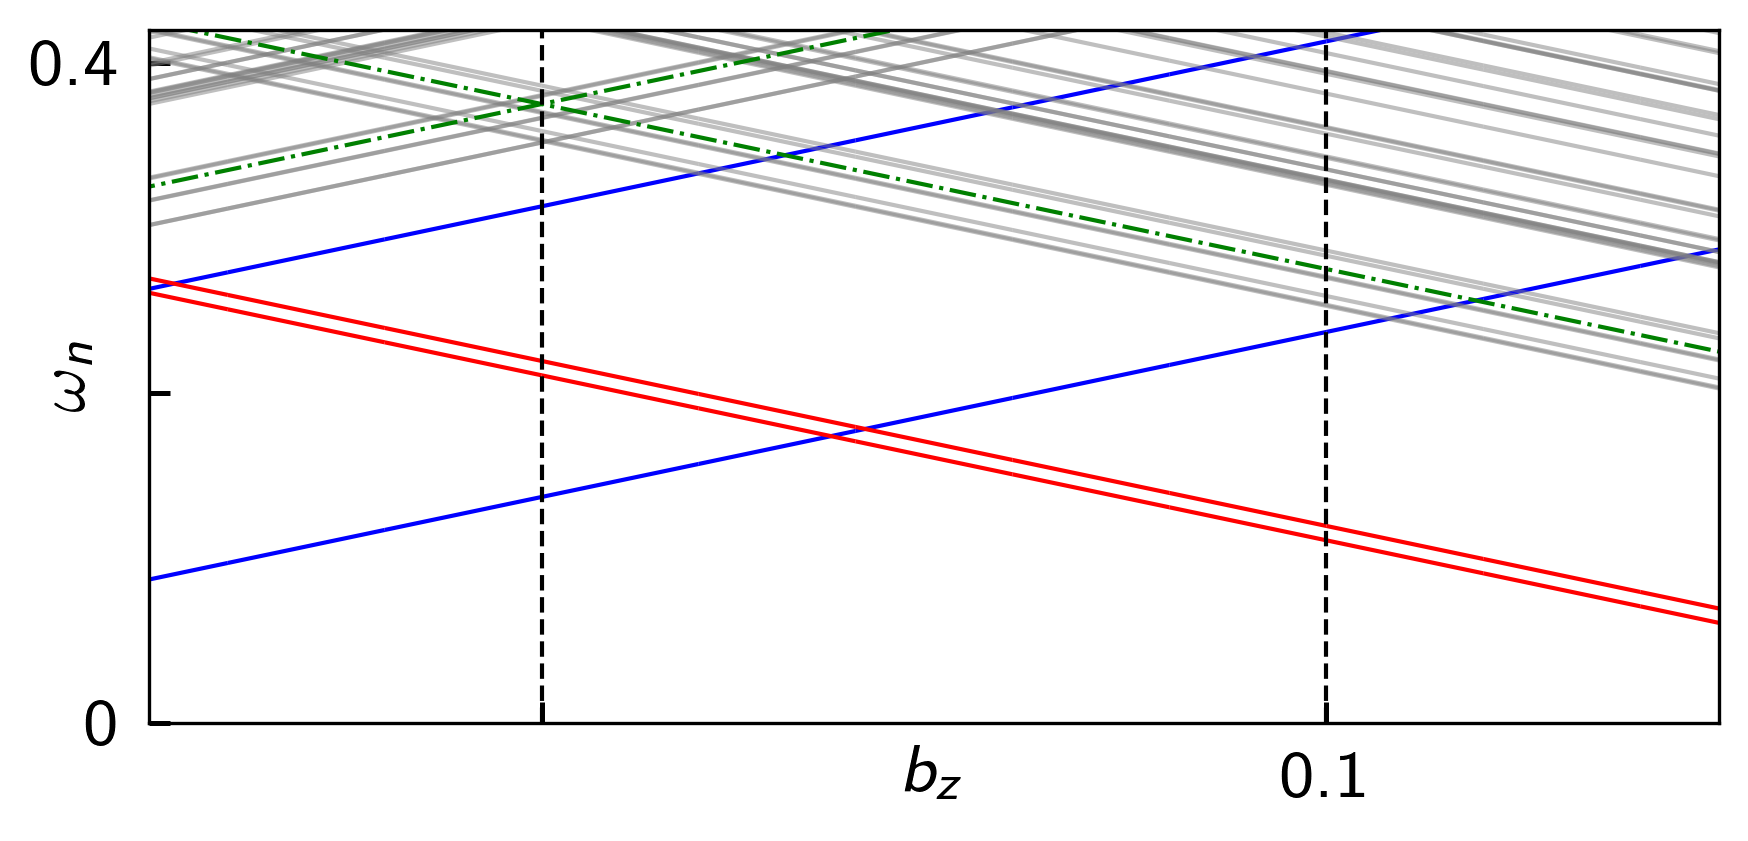

In [53]:
fig, ax = plt.subplots(figsize=(3.375, 1.5), dpi=600)

multiplot(bs, wss, colors=colors)

ax.plot(bs, Delta_init - mu * t_am / t - bs, "-.", color="green")
ax.plot(bs, Delta_init - mu * t_am / t + bs, "-.", color="green")

ax.vlines([0, 0.1], 0, 0.45, color="black", linestyles="dashed")

ax.set_xticks([-0.1, 0, 0.1], labels=["-0.1", "", "0.1"])
ax.set_yticks([0, 0.2, 0.4], labels=["0", "", "0.4"])

ax.set_xlabel(r"$b_z$", labelpad=-8)
ax.set_ylabel(r"$\omega_n$", labelpad=-8)
ax.set_ylim(0, 0.42)
ax.set_xlim(-0.05, 0.15)

fig.savefig("./imgs/Fig4_spectrum_v19w22.svg", dpi=1200)

In [51]:
idxp = [P // 2, np.argmin(abs(bs - 0.1))]
idxs = [(-1 / (wss[idxp[0]])).argsort()[0], (-1 / (wss[idxp[1]])).argsort()[0]]

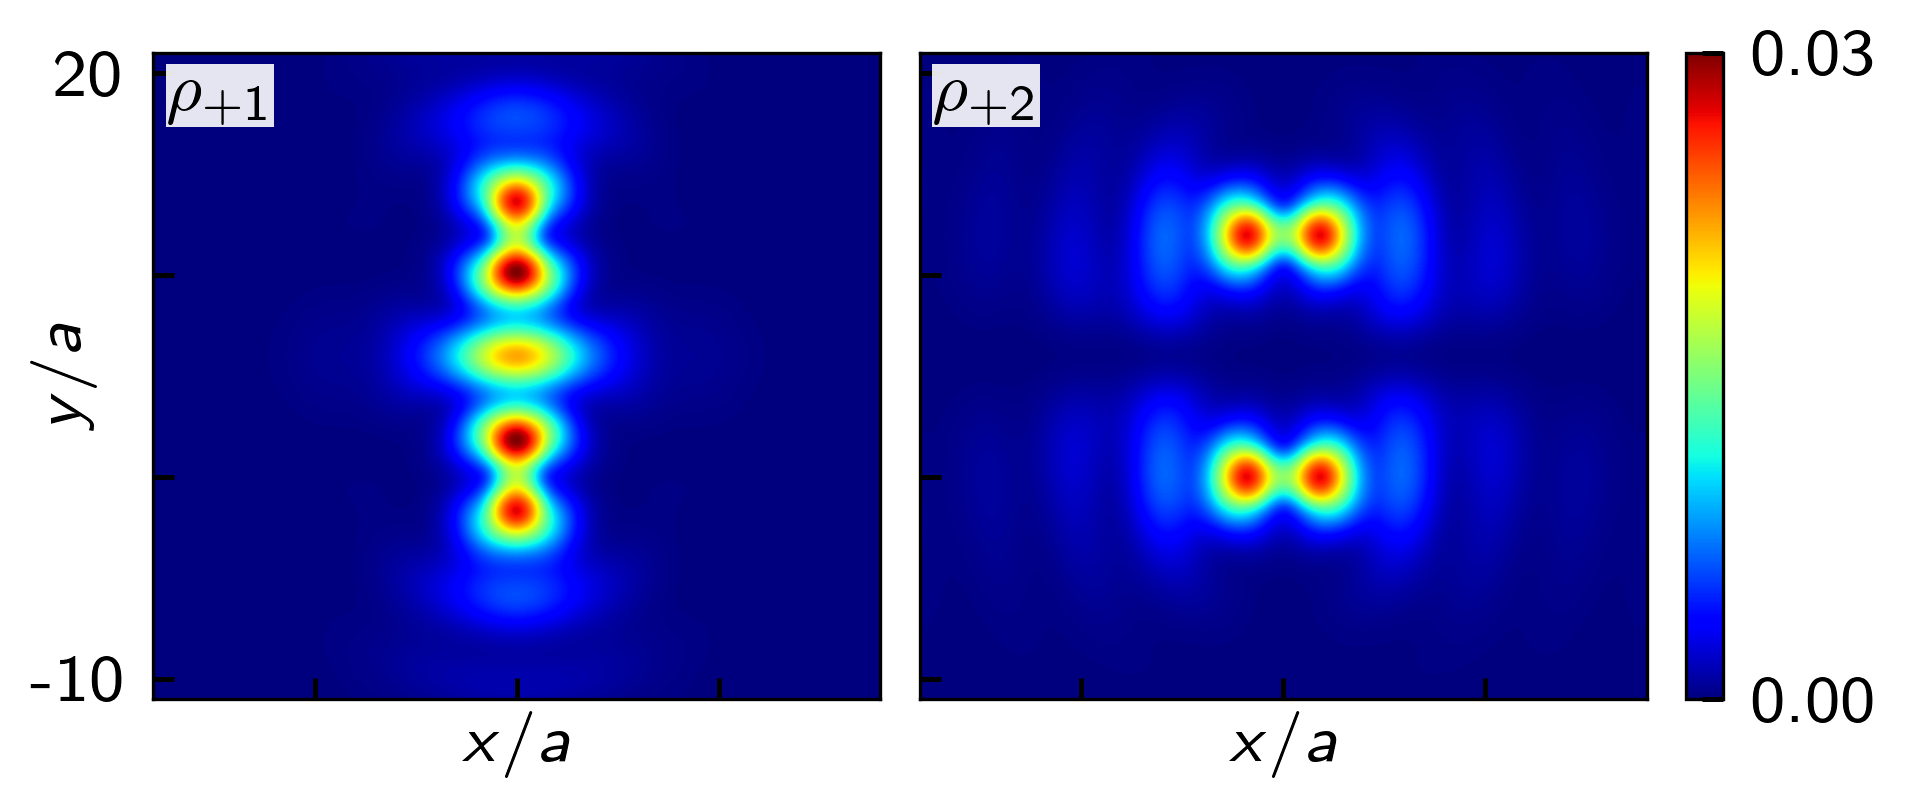

In [52]:
d_1 = t0s0_op(vss[idxp[0], :, idxs[0]])
d_2 = t0s0_op(vss[idxp[1], :, idxs[1]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 1.4))
# gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.08, hspace=0.08)


# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# ax3 = fig.add_subplot(gs[0, 2])
# ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 2])

# Determine color limits
vmax = np.max(np.abs([d_1, d_2]))  # , d_3, d_4]))
vmin = 0

cmap = "jet"
im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax)
im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax)
# im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax)
# im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax)

# # Determine color limits
# vmax = np.max(np.abs([m_1, m_2, m_3, m_4]))
# vmin = -vmax

# # Plot densities with kwant.plotter.density
# im1m = kwant.plotter.density(fsyst, m_1, ax=ax1, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im2m = kwant.plotter.density(fsyst, m_2, ax=ax2, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im3m = kwant.plotter.density(fsyst, m_3, ax=ax3, cmap="RdBu_r", vmin=vmin, vmax=vmax)
# im4m = kwant.plotter.density(fsyst, m_4, ax=ax4, cmap="RdBu_r", vmin=vmin, vmax=vmax)


# for ax in [ax1, ax2, ax3, ax4]:
#     ax.images[0].set_alpha(0.5)
#     ax.images[1].set_alpha(0.5)

# Set lims
xlims = (-18, 18)
ylims = (-11, 21)
for ax in [ax1, ax2]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10, 20], labels=["-10", "", "", "20"])
for ax in [ax2]:
    ax.set_yticks([-10, 0, 10, 20], labels=[])

for ax in [ax1, ax2]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])


ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
# ax3.set_xlabel(r"$x/a$", labelpad=-2)
# ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2]:  # , ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)

# Add titles for each subplot
add_tl_label(ax1, r"$\rho_{+1}$")
add_tl_label(ax2, r"$\rho_{+2}$")
# add_tl_label(ax3, r"$\mu_{+3}$")
# add_tl_label(ax4, r"$\mu_{+4}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap=cmap)
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])
fig.savefig("./imgs/Fig4_ldos_v19w22.svg", dpi=1200)